In [1]:
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import (
                                    StratifiedKFold, 
                                    GridSearchCV
                                    )
from sklearn.metrics import confusion_matrix
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [2]:
X_train = np.load("../artifacts/X_train_resampled.npz", allow_pickle=True)['arr_0']
Y_train = np.load("../artifacts/Y_train_resampled.npz", allow_pickle=True)['arr_0']
X_test = np.load('../artifacts/X_test.npz', allow_pickle=True)['arr_0']
Y_test = np.load('../artifacts/Y_test.npz', allow_pickle=True)['arr_0']

In [3]:
# Logistic Regression
lr_param_grid = {
    'max_iter': [1000, 5000, 10000]
}

# Decision Tree
dt_param_grid = {
    'max_depth': [8, 12, 16, 20],
    'criterion': ["gini", "entropy", "log_loss"]
}

# Random Forest
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [8, 12],
    'criterion': ["gini", "entropy", "log_loss"]
}

# XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# CatBoost
cat_param_grid = {
    'iterations': [100, 200],
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5]
}

# Combine into one dictionary
param_grids = {
    'Logistic Regression': lr_param_grid,
    'Decision Tree': dt_param_grid,
    'Random Forest': rf_param_grid,
    'XGBoost': xgb_param_grid,
    'CatBoost': cat_param_grid
}


In [4]:

models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(
                    use_label_encoder=False, 
                    eval_metric='logloss', 
                    random_state=42
                ),
    'CatBoost': CatBoostClassifier(
                    verbose=0, 
                    random_state=42
                )
}


In [5]:
cv = StratifiedKFold(
                    n_splits=6,
                    random_state=42,
                    shuffle=True
                    )

In [6]:
grid_search_results = {}
for model_name, model in models.items():
    print(f"\n--- Tuning {model_name} ---")

    param_grid = param_grids[model_name]

    grid_search = GridSearchCV(
                                estimator=model,
                                param_grid=param_grid,
                                cv=cv, scoring='f1',
                                verbose=1, return_train_score=False
                                )
    
    print(f"Fitting gridSearchCV for {model_name}")

    grid_search.fit(X_train, Y_train)

    grid_search_results[model_name] = grid_search
    
    print(f"{model_name} gridSearchCV completed ...")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_}")


--- Tuning Logistic Regression ---
Fitting gridSearchCV for Logistic Regression
Fitting 6 folds for each of 3 candidates, totalling 18 fits
Logistic Regression gridSearchCV completed ...
Best parameters: {'max_iter': 1000}
Best CV score: 0.8400021668267413

--- Tuning Decision Tree ---
Fitting gridSearchCV for Decision Tree
Fitting 6 folds for each of 12 candidates, totalling 72 fits
Decision Tree gridSearchCV completed ...
Best parameters: {'criterion': 'log_loss', 'max_depth': 12}
Best CV score: 0.8067835287695804

--- Tuning Random Forest ---
Fitting gridSearchCV for Random Forest
Fitting 6 folds for each of 12 candidates, totalling 72 fits
Random Forest gridSearchCV completed ...
Best parameters: {'criterion': 'gini', 'max_depth': 12, 'n_estimators': 200}
Best CV score: 0.8584728782667636

--- Tuning XGBoost ---
Fitting gridSearchCV for XGBoost
Fitting 6 folds for each of 36 candidates, totalling 216 fits
XGBoost gridSearchCV completed ...
Best parameters: {'learning_rate': 0.1, '

In [10]:
grid_search_results['CatBoost'].best_params_

{'depth': 8, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

In [11]:
# Find the best model across all models based on CV score
best_model_name = max(grid_search_results, key=lambda x: grid_search_results[x].best_score_)
best_model = grid_search_results[best_model_name].best_estimator_
best_score = grid_search_results[best_model_name].best_score_
best_params = grid_search_results[best_model_name].best_params_

print(f"Best model: {best_model_name}")
print(f"Best CV F1 score: {best_score:.4f}")
print(f"Best parameters: {best_params}")

# Save the best model
joblib.dump(best_model, f"../artifacts/best_model_{best_model_name.replace(' ', '_').lower()}.pkl")

# Save all grid search results for future reference
joblib.dump(grid_search_results, "../artifacts/all_grid_search_results.pkl")

print(f"\nBest model saved as: best_model_{best_model_name.replace(' ', '_').lower()}.pkl")
print("All grid search results saved as: all_grid_search_results.pkl")

Best model: CatBoost
Best CV F1 score: 0.8626
Best parameters: {'depth': 8, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

Best model saved as: best_model_catboost.pkl
All grid search results saved as: all_grid_search_results.pkl


Demonstrating threshold optimization with: CatBoost


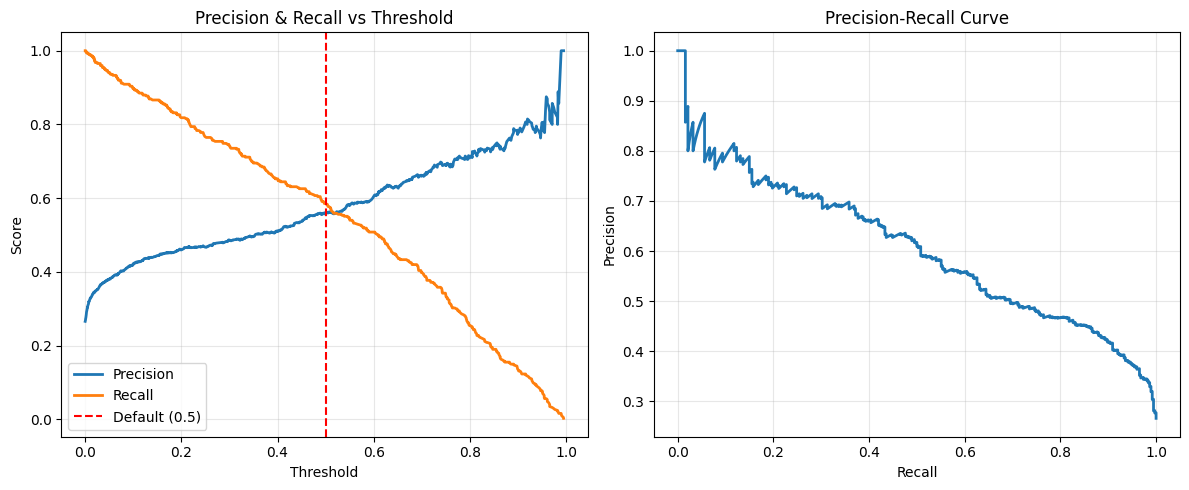


Threshold Impact Analysis:
Threshold | Precision | Recall | F1-Score | Business Impact
-----------------------------------------------------------------
  0.1     |   0.421   |  0.898  |  0.573
  0.2     |   0.460   |  0.818  |  0.589
  0.3     |   0.485   |  0.741  |  0.586
  0.4     |   0.512   |  0.652  |  0.573
  0.5     |   0.562   |  0.586  |  0.573
  0.6     |   0.605   |  0.508  |  0.552
  0.7     |   0.662   |  0.398  |  0.497
  0.8     |   0.714   |  0.254  |  0.375
  0.9     |   0.781   |  0.134  |  0.228
